<a href="https://colab.research.google.com/github/duwei0227/pytorch-book-learning/blob/master/chapter5-%E5%B8%B8%E7%94%A8%E5%B7%A5%E5%85%B7/PyTorch%E5%B8%B8%E7%94%A8%E5%B7%A5%E5%85%B7%E6%A8%A1%E5%9D%97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
os.chdir('/content/gdrive/My Drive/Notebook')

### 数据处理
#### 数据加载
自定义数据集需要继承Dataset，并实现以下2个方法：
* `__getitem__`：返回一条数据，或一个样本
* `__len__`：返回样本的数量

In [0]:
import torch
from torch.utils import data

In [0]:
import os
from PIL import Image
import numpy as np

In [0]:
class DogCat(data.Dataset):
  def __init__(self, root):
    imgs = os.listdir(root)
    
    # 所有图片的绝对路径
    # 这里不实际加载图片，只是指定路径，当调用__getitem__时才会真正读图片
    self.imgs = [os.path.join(root, img) for img in imgs]
    
  def __getitem__(self, index):
    img_path = self.imgs[index]
    # dog -> 1  cat -> 0
    label = 1 if 'dog' in img_path.split('/')[-1] else 0
    pil_img = Image.open(img_path)
    array = np.asarray(pil_img)
    data = torch.from_numpy(array)
    return data, label
  
  def __len__(self):
    return len(self.imgs)

In [32]:
dataset = DogCat('./images/dogcat')
img, label = dataset[0]

for img, label in dataset:
  print(img.size(), img.float().mean(), label)

torch.Size([375, 499, 3]) tensor(150.5079) 1
torch.Size([400, 300, 3]) tensor(128.1550) 1
torch.Size([500, 497, 3]) tensor(106.4915) 0
torch.Size([377, 499, 3]) tensor(151.7174) 1
torch.Size([236, 289, 3]) tensor(130.3004) 0
torch.Size([375, 499, 3]) tensor(116.8138) 1
torch.Size([499, 379, 3]) tensor(171.8085) 0
torch.Size([374, 499, 3]) tensor(115.5177) 0


针对图片样本的大小不一样，返回样本的数值较大，未归一化到至[-1, 1]。PyTorch提供了torchvision，它是一个视觉工具包，提供了很多视觉图像处理的工具包，其中transform提供了如下操作：  
对PIL Image的操作：  
* Scale：调整图片尺寸，长宽比保持不变
* Crop：CenterCrop、RandomCrop、RandomResizedCrop 裁剪图片
* Pad：填充
* ToTensor： 将PIL Image转为Tensor，会自动将[0, 255]归一化至[0,1]

对Tensor的操作：
* Normailze：标准化，即减均值，除以标准差 $\frac{x - \mu}{std}$
* ToPILImage：将Tensor转为PIL Image对象

如果对图片进行多个操作，可通过Compose函数将这些操作连接起来

In [0]:
import os
from PIL import Image
import numpy as np
from torchvision import transforms as T

In [0]:
transform = T.Compose([
    T.Resize(224), # 缩放图片，保持长宽比不变，最短边为224像素
    T.CenterCrop(224), # 从图片中间切出 224 * 224的图片
    T.ToTensor(), # 将图片转成Tensor，归一化至[0, 1]
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 标准化至[-1, 1]，规定均值和标准差
])

In [0]:
class DogCat(data.Dataset):
  def __init__(self, root, transforms=None):
    imgs = os.listdir(root)
    self.imgs = [os.path.join(root, img) for img in imgs]  # 所有图片路径
    self.transforms = transforms
    
  def __getitem__(self, index):
    img_path = self.imgs[index]
    label = 0 if 'dog' in img_path.split('/')[-1] else 1  # 图片label
    data = Image.open(img_path)
    if self.transforms:
      data = self.transforms(data)
    return data, label
  
  def __len__(self):
    return len(self.imgs)
    
     

In [36]:
dataset = DogCat('./images/dogcat', transforms=transform)
img, label = dataset[0]
for img, label in dataset:
  print(img.size(), label)

torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 1


transforms还可以通过Lambda封装自定义的转换策略。例如相对PIL Image进行随机旋转，则可以写成
`trans = transforms.Lambda(lambda img: img.rotate(random() * 360))`

ImageFolder假设所有的文件按文件夹保存，每个文件夹下存储同一个类别的图片，文件夹名为类名，其构造函数如下：  
`ImageFolder(root, transform=None, target_transform=None,loader=default_loader)`
四个主要参数：
* root：在root指定的路径下寻找图片
* transform：对PIL Image进行的转换操作，transform的输入是使用loader读取图片的返回对象
* target_transform：对label的转换
* loader：给定路径后如何读取图片，默认读取为RGB格式的PIL Image对象

label是按照文件夹名按顺序排序后存成字典，即{类名: 类序号(从0开始)}

In [0]:
from torchvision.datasets import ImageFolder

In [38]:
ls images/dogcat_2/cat

'cat.12484 (1).jpg'   cat.12485.jpg   cat.12487.jpg
 cat.12484.jpg        cat.12486.jpg


In [0]:
dataset = ImageFolder(root='./images/dogcat_2')

In [40]:
dataset.class_to_idx

{'cat': 0, 'dog': 1}

In [41]:
# 所有图片的路径和对应的label
dataset.imgs

[('./images/dogcat_2/cat/cat.12484 (1).jpg', 0),
 ('./images/dogcat_2/cat/cat.12484.jpg', 0),
 ('./images/dogcat_2/cat/cat.12485.jpg', 0),
 ('./images/dogcat_2/cat/cat.12486.jpg', 0),
 ('./images/dogcat_2/cat/cat.12487.jpg', 0),
 ('./images/dogcat_2/dog/dog.12496.jpg', 1),
 ('./images/dogcat_2/dog/dog.12497.jpg', 1),
 ('./images/dogcat_2/dog/dog.12498.jpg', 1),
 ('./images/dogcat_2/dog/dog.12499.jpg', 1)]

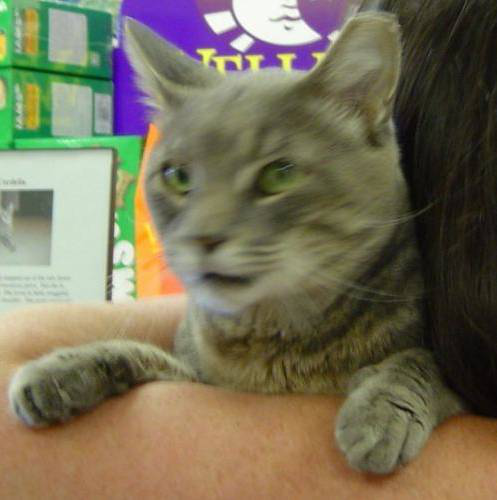

In [42]:
# 没有进行任何的transform，所以返回的还是PIL Image对象
# 第一维表示第几张图片，第二位0表示数据，1表示label
dataset[0][1]
dataset[0][0]

In [0]:
# 加上transforms

normalize = T.Normalize(mean=[0.4, 0.4, 0.4], std=[0.2, 0.2, 0.2])

transform = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    normalize
])

In [0]:
dataset = ImageFolder(root='./images/dogcat_2', transform=transform)

In [45]:
# 深度学习中图片数据一般保存成 C*H*W，即通道数*图片高*图片宽
dataset[0][0].size()

torch.Size([3, 224, 224])

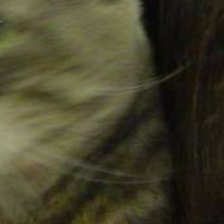

In [46]:
to_img = T.ToPILImage()
# 0.2 和 0.4是标准差和均值的近似，对数据的还原 (x - mean) / std
to_img(dataset[0][0] * 0.2 + 0.4)

Dataset只负责数据的抽取，一次调用__getitem__只返回一个样本。但是在训练神经网络的时候，最好是对一个batch的数据进行操作，同时还需要对数据进行shuffle和并行加速等。PyTorch提供了DataLoader。  
DataLoader的定义如下：
`
DataLoader(dataset, batch_size=1, shuffle=False, sampler=None, num_workers=0, collate_fn=default_collate, pin_memory=False, drop_last=False)
`
* dataset：加载的数据集（Dataset对象）
* batch_size：batch_size
* shuffle：是否随机打乱数据
* sampler：样本抽样
* num_workers：使用多进程加载的进程数
* collate_fn：如何将多个样本数据拼接成一个batch，一般使用默认的拼接方式即可
* pin_memory：是否将数据保存在pin momory区，pin memory中的数据转换到GPU会快一些
* drop_last：dataset中的数据个数可能不是batch_size的整数倍，drop_last为True会将多出来不足一个batch的数据丢弃

In [0]:
from torch.utils.data import DataLoader

In [0]:
dataloader = DataLoader(dataset, batch_size=3, shuffle=True, num_workers=0, drop_last=False)

In [54]:
dataiter = iter(dataloader)
imgs, label = next(dataiter)
imgs.size()  # batch_size, channel, height, weight

torch.Size([3, 3, 224, 224])

处理异常图片最好方案是将出错的样本剔除；如果实在无法处理，可以返回None对象；然后在DataLoader中实现自定义的 collate_fn，将空对象过滤掉，但此种情况batch_size会变小。另外一种处理异常图片的方式是随机取一张图片代替

In [0]:
class NewDogCat(DogCat):
  def __getitem__(self, index):
    try:
      # 调用父类的获取函数，即DogCat.__getitem__(index)
      return super(NewDogCat, self).__getitem__(index)
    except:
      return None, None

In [0]:
from torch.utils.data.dataloader import default_collate

In [0]:
def my_collate_fn(batch):
  """batch中每个元素形如(data, label)"""
  # 过滤为None的数据
  batch = list(filter(lambda x: x[0] is not None, batch))
  if len(batch) == 0:
    return torch.Tensor()
  return default_collate(batch) # 用默认方式拼接过滤后的batch数据

sampler模块对数据进行采样。常见的有随机采样：RandomSampler，当dataloader的shuffle=True时，系统自动调用。默认采用的是SequentialSampler，它会按顺序一个一个采样。另外一种WeightedRandomSampler，它会根据样本的权重选取数据，在样本比例不平衡的问题中，可以用它来进行重采样。  
构建WeightedRandomSampler时需提供两个参数：每个样本的权重weights、共选取的样本总数num_samples，以及一个可选参数replacement。权重远大的样本被选中的概率越大，待选取的样本数目一般小于全部的样本数目。replacement用于指定是否可以重复选取某一个样本，默认为True，即允许在一个epoch中重复采样某一个数据；如果设为False，可能会出现某一类的样本全部被选取完，但样本数目仍未达到num_samples，此时可能导致weights参数失效

In [9]:
dataset = DogCat('./images/dogcat', transforms=transform)

# 狗的图片被取出的概率是猫的概率的两倍
# 两类图片被取出的概率与weights的绝对大小无关，只和比值有关
weights = [2 if label == 1 else 1 for data, label in dataset]
weights

[1, 1, 2, 1, 2, 1, 2, 2]

In [0]:
from torch.utils.data.sampler import WeightedRandomSampler

In [12]:
sampler = WeightedRandomSampler(weights, num_samples=9, replacement=True)

dataloader = DataLoader(dataset, batch_size=3, sampler=sampler)
for data, label in dataloader:
  print(label.tolist())

[1, 1, 0]
[1, 0, 1]
[1, 1, 1]


### 视觉工具包：torchvision
主要包含三部分：
* models：提供深度学习中各种经典网络的网络结构以及预训练好的模型，包括AlexNet, VGG系列、ResNet系列、Inception系列等
* datasets：提供常用的数据集加载，设计上都是继承torch.utils.data.Dataset，主要包括MNIST、CIFAR10/100、ImageNet、COCO等
* transforms：提供常用的数据预处理操作，主要包括对Tensor以及PIL Image对象的操作


In [0]:
from torchvision import models
from torch import nn

In [0]:
# 加载预训练好的模型，如果不存在会进行下载
# 预训练好的模型保存在 ~/.torch/models/下面
resnet34 = models.squeezenet1_1(pretrained=True, num_classes=1000)

# 修改最后的全连接层为10分类问题（默认是ImageNet）上的1000分类
resnet34.fc = nn.Linear(512, 10)

In [0]:
from torchvision import datasets

In [0]:
# 指定数据集路径为data，如果数据集不存在则下载
# 通过train=False获取测试集
dataset = datasets.MNIST('./data', download=True, train=False, transform=transform)

In [0]:
from torchvision import transforms

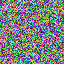

In [60]:
to_pil = transforms.ToPILImage()
to_pil(torch.randn(3, 64, 64))

torchvison 还提供了两个常用函数。一个是make_grid，它能将多张图片拼接成一个网格中；另一个是save_img，它能够将Tensor保存成图片

In [61]:
len(dataset)

10000

In [0]:
dataloader = DataLoader(dataset, shuffle=True, batch_size=16)

In [0]:
from torchvision.utils import make_grid, save_image

In [0]:
# 报错了
dataiter = iter(dataloader)
img = make_grid(next(dataiter)[0], 4) # 拼成4*4网格图片，且会转成３通道
to_img(img)

### 可视化工具
#### Visidom
两个重要概念：
* env：环境。不同环境的可视化结果相互隔离，互不影响，默认使用main
* pane：窗格。窗格可用于可视化图像、数值或打印文本

In [68]:
%%sh
# 启动visdom服务器
# pip install visdom
nohup python -m visdom.server &

/usr/bin/python2: No module named visdom


In [0]:
import visdom

In [0]:
import torch

In [0]:
# 新建一个连接客户端
vis = visdom.Visdom(env=u'test1', use_incoming_socket=False)

x = torch.arange(1, 30, 0.01)
y = torch.sin(x)
vis.line(X=x, Y=y, opts={'titls':'y=sin(x)'})